In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactiveity = 'all'

import numpy as np
import pandas as pd
import torch
import yfinance as yf
import hmmlearn.hmm as hmm
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn; seaborn.set()

In [2]:
russell = yf.download("^RUA")
russell

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-09-10,178.960007,178.960007,177.050003,178.830002,178.830002,0
1987-09-11,178.830002,181.470001,178.830002,181.339996,181.339996,0
1987-09-14,181.339996,182.250000,180.750000,181.789993,181.789993,0
1987-09-15,181.789993,181.789993,179.259995,179.270004,179.270004,0
1987-09-16,179.270004,180.630005,177.860001,177.889999,177.889999,0
...,...,...,...,...,...,...
2022-01-24,2551.000000,2569.959961,2452.550049,2565.949951,2565.949951,0
2022-01-25,2563.280029,2563.889893,2493.129883,2531.379883,2531.379883,0
2022-01-26,2535.689941,2587.969971,2499.520020,2523.629883,2523.629883,0


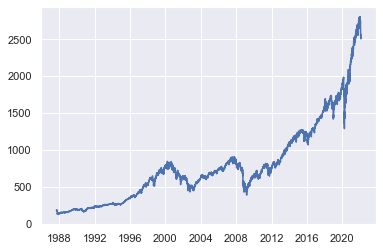

In [3]:
plt.plot(russell['Adj Close'])

In [76]:
russell['ret'] = russell['Adj Close'] / russell['Adj Close'].shift(1) - 1
df = russell[['Adj Close', 'ret']].dropna()
df

,Adj Close,ret
Date,,
1987-09-11,181.339996,0.014036
1987-09-14,181.789993,0.002482
1987-09-15,179.270004,-0.013862
1987-09-16,177.889999,-0.007698
1987-09-17,177.839996,-0.000281
...,...,...
2022-01-24,2565.949951,0.005254
2022-01-25,2531.379883,-0.013473
2022-01-26,2523.629883,-0.003062


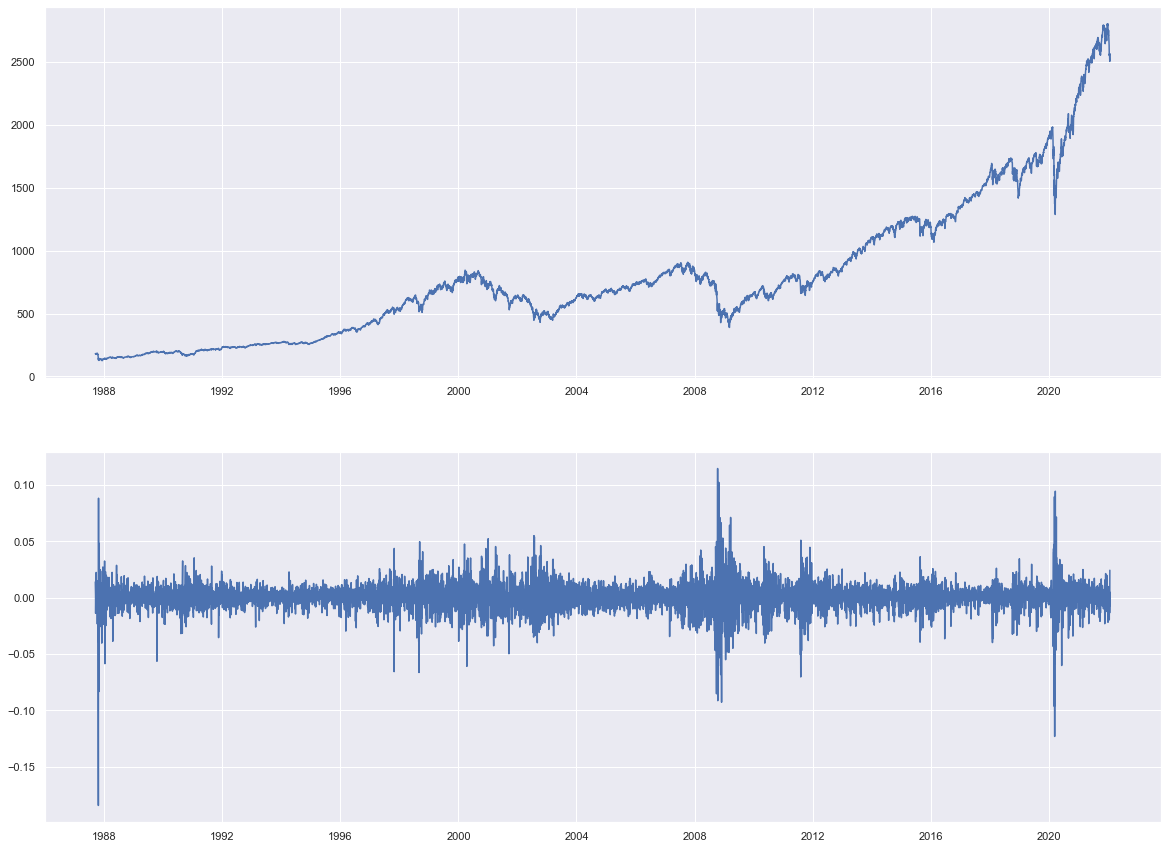

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

for i, ax in enumerate(axes):
    ax.plot(df[df.columns[i]])

# 检测hmm效果

In [6]:
dates = np.array(df.index)
X = np.array(df['ret']).reshape(-1, 1)
X

array([[ 0.01403565],
       [ 0.00248151],
       [-0.01386209],
       ...,
       [-0.00306157],
       [-0.00712068],
       [ 0.02439526]])

In [7]:
model = hmm.GaussianHMM(n_components=2, covariance_type='diag', n_iter=1000).fit(X)
hidden_states = model.predict(X)

print(model.transmat_)
print(model.predict_proba)

print('Means and vars of each hidden state :')
params = pd.DataFrame(columns = ('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i], np.diag(model.covars_[i])]
    
params

[[0.96022031 0.03977969]
 [0.01191607 0.98808393]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=2, n_iter=1000)>
Means and vars of each hidden state :


,State,Means,Variance
0,0,[-0.0010539014975935158],[0.0004231027482021256]
1,1,[0.0008002375926778744],[5.1676918112957016e-05]


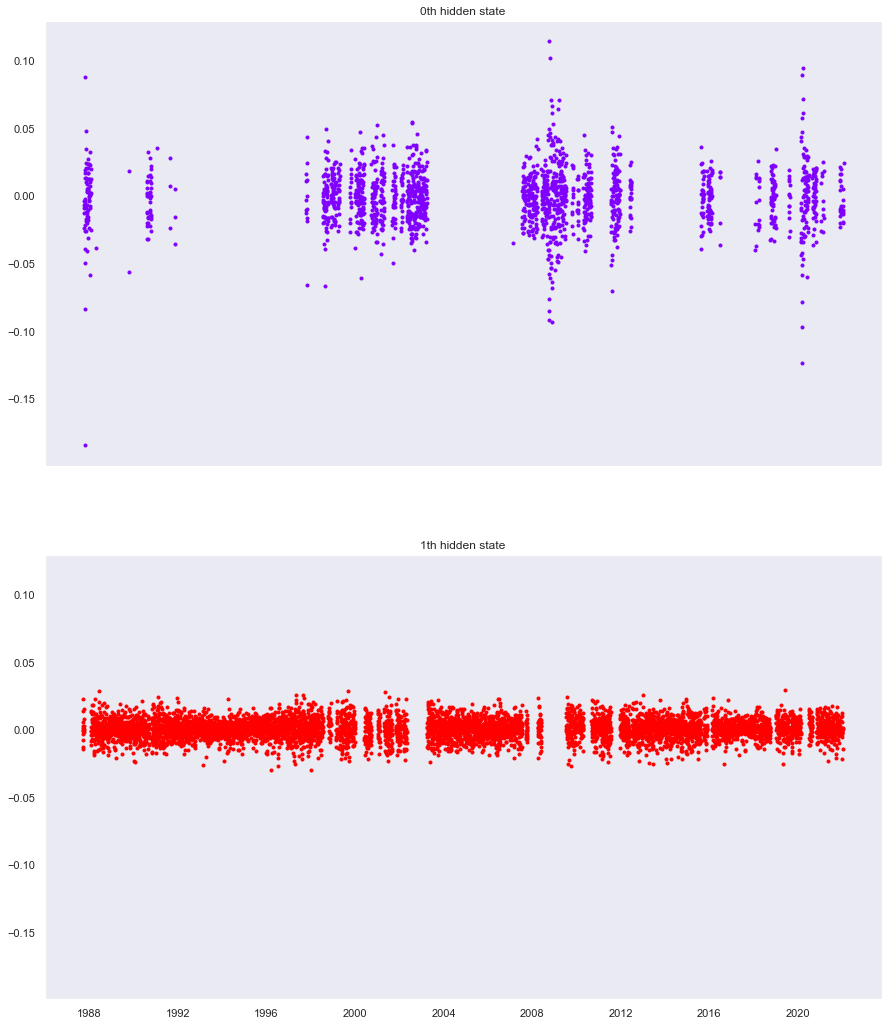

In [8]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,18))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colours)):
    mask = hidden_states == i
    ax.plot_date(dates[mask], X.reshape(-1)[mask], '.', c=color)
    ax.set_title('{}th hidden state'.format(i))
    
#     ax.xaxis.set_major_locator(YearLocator())
#     ax.xaxis.set_minor_locator(MonthLocator())
    
    ax.grid()
plt.show()

In [9]:
df['state'] = hidden_states
df

,Adj Close,ret,state
Date,,,
1987-09-11,181.339996,0.014036,1
1987-09-14,181.789993,0.002482,1
1987-09-15,179.270004,-0.013862,1
1987-09-16,177.889999,-0.007698,1
1987-09-17,177.839996,-0.000281,1
...,...,...,...
2022-01-24,2565.949951,0.005254,0
2022-01-25,2531.379883,-0.013473,0
2022-01-26,2523.629883,-0.003062,0


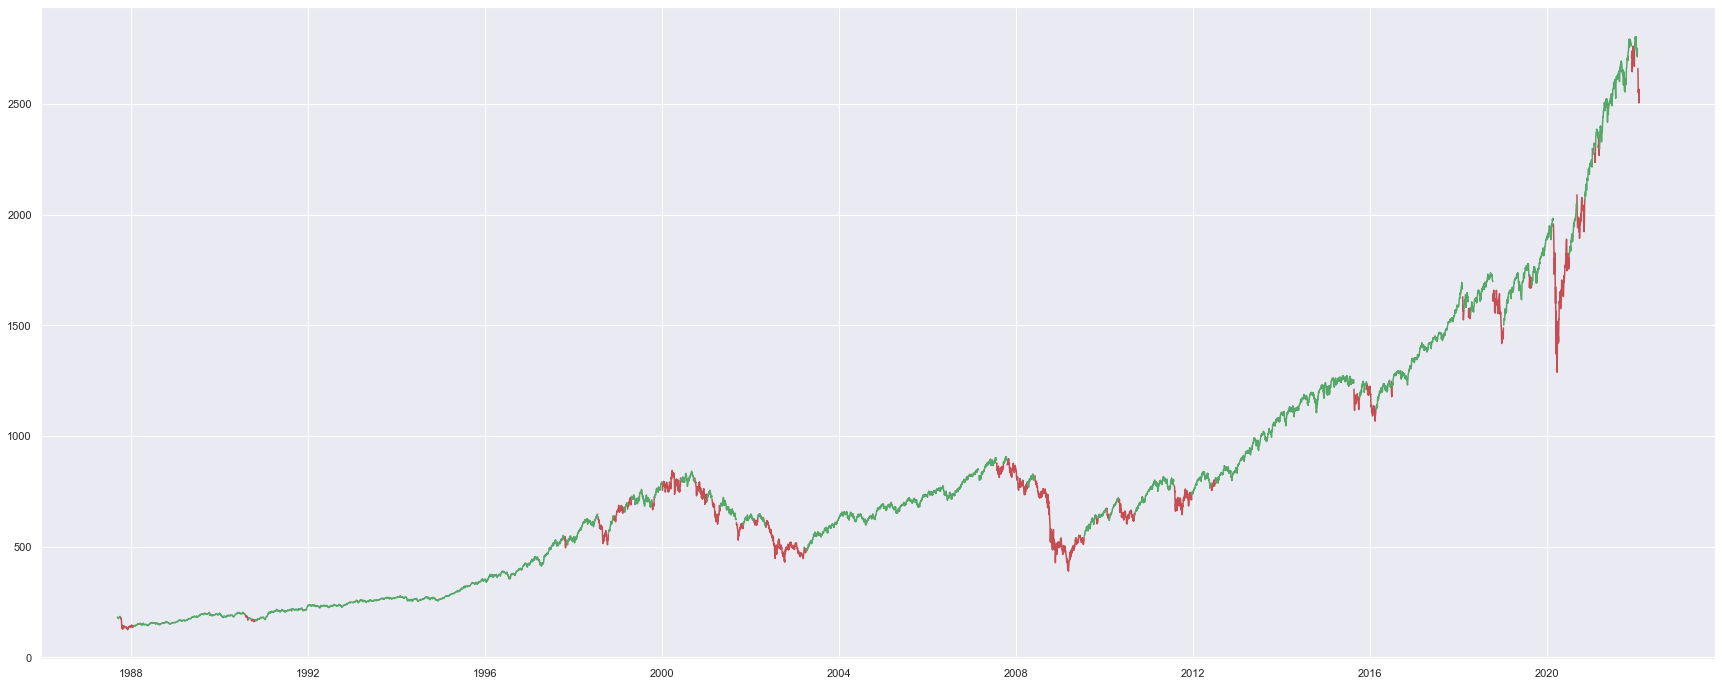

In [10]:
ret0 = df[df['state'] == 0]['Adj Close']
ret0 = ret0.reindex(df.index)
ret1 = df[df['state'] == 1]['Adj Close']
ret1 = ret1.reindex(df.index)
# ret2 = df[df['state'] == 2]['Adj Close']
# ret2 = ret2.reindex(df.index)
plt.figure(figsize=(30, 12))
plt.plot(ret0, color='r')
plt.plot(ret1, color='g')
# plt.plot(ret2, color='b')
plt.show()

# 分集合训练和预测

In [74]:
train = df[df.index < '2018-01-01']
test = df[df.index >= '2018-01-01']

In [37]:
X_train = np.array(train['ret']).reshape(-1, 1)
X_test = np.array(test['ret']).reshape(-1, 1)
model = hmm.GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000).fit(X_train)
hidden_states = model.predict(X_train)

print(model.transmat_)
print(model.predict_proba)

print('Means and vars of each hidden state :')
params = pd.DataFrame(columns = ('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i], np.diag(model.covars_[i])]
    
params

[[2.44655613e-01 1.07102762e-01 2.95279824e-06 6.48238672e-01]
 [1.86952835e-02 9.71116729e-01 7.95176487e-03 2.23622234e-03]
 [3.29629344e-07 3.69874088e-02 9.63012261e-01 3.90820164e-10]
 [5.92999114e-02 1.20052807e-03 5.70465695e-10 9.39499560e-01]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=4, n_iter=1000)>
Means and vars of each hidden state :


,State,Means,Variance
0,0,[-0.001836628708762601],[0.000186512308368126]
1,1,[6.783161284074939e-05],[0.00014735361299039745]
2,2,[-0.0017454958376367999],[0.0008630116239868193]
3,3,[0.0009448474456011983],[3.547827626395653e-05]


In [71]:
def calculate_AIC_BIC():
    for i in range(2, 5):
        X_train = np.array(train['ret']).reshape(-1, 1)
        X_test = np.array(test['ret']).reshape(-1, 1)
        model = hmm.GaussianHMM(n_components=i, covariance_type='diag', n_iter=1000).fit(X_train)
        hidden_states = model.predict(X_train)
        num_states = i
        print('num_states:', num_states)
        print('score:', model.score(X_train))
        print('AIC = ', 2 * (num_states ** 2 + num_states + len(X_train[1]) * num_states + len(X_train[1]) ** num_states) - 2 * model.score(X_train))
        print('BIC = ', (num_states ** 2 + num_states + len(X_train[1]) * num_states + len(X_train[1]) ** num_states) * np.log(len(X_train)) - 2 * model.score(X_train))
    
calculate_AIC_BIC()

num_states: 2
score: 24882.569284506117
AIC =  -49747.13856901223
BIC =  -49684.66937116036
num_states: 3
score: 25194.316664260754
AIC =  -50356.63332852151
BIC =  -50245.57697678485
num_states: 4
score: 25212.942978873267
AIC =  -50375.885957746534
BIC =  -50202.360408158


In [40]:
pred_hidden_states=model.decode(X_test, algorithm='viterbi')[1]
test['pred_states'] = pd.Series(pred_hidden_states, index=test.index)
test

,Adj Close,ret,state,pred_states
Date,,,,
2018-01-02,1595.869995,0.008277,1,1
2018-01-03,1605.189941,0.005840,1,1
2018-01-04,1611.020020,0.003632,1,1
2018-01-05,1621.369995,0.006424,1,1
2018-01-08,1624.349976,0.001838,1,1
...,...,...,...,...
2022-01-24,2565.949951,0.005254,0,1
2022-01-25,2531.379883,-0.013473,0,1
2022-01-26,2523.629883,-0.003062,0,1


In [43]:
test[test['pred_states'] == 0]

,Adj Close,ret,state,pred_states
Date,,,,
2018-04-10,1574.670044,0.016894,1,0
2018-10-10,1642.770020,-0.032430,0,0
2019-01-30,1583.040039,0.014945,1,0
2019-05-13,1656.760010,-0.025309,1,0
2019-06-05,1664.119995,0.029726,1,0
2019-07-31,1754.650024,-0.010372,1,0
2019-09-05,1742.900024,0.013243,1,0
2019-10-01,1720.119995,-0.012957,1,0
2019-10-02,1691.050049,-0.016900,1,0


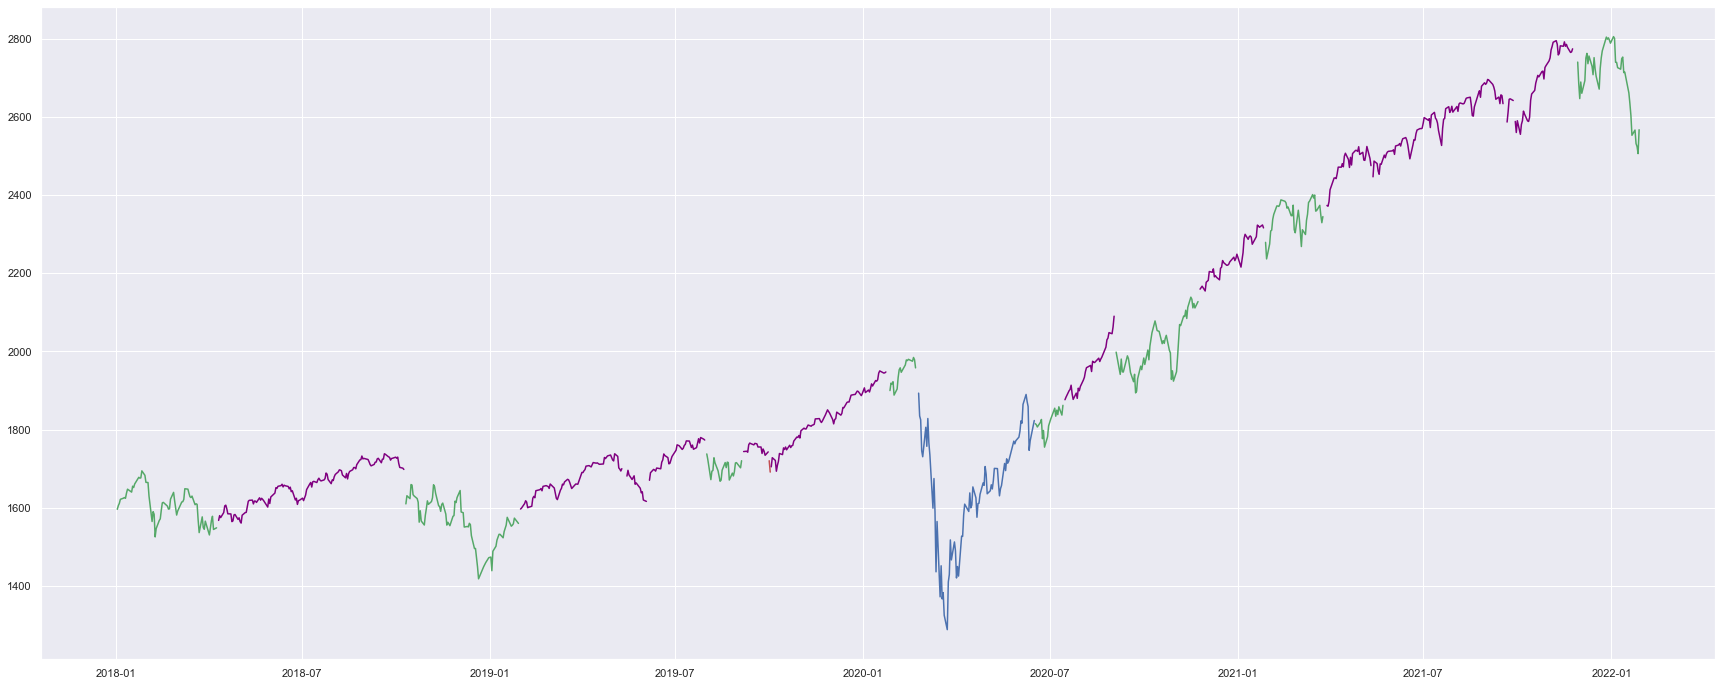

In [41]:
test['pred_states'].shift(1)
ret0 = test[test['pred_states'] == 0]['Adj Close']
ret0 = ret0.reindex(df.index)
ret1 = test[test['pred_states'] == 1]['Adj Close']
ret1 = ret1.reindex(df.index)
ret2 = test[test['pred_states'] == 2]['Adj Close']
ret2 = ret2.reindex(df.index)
ret3 = test[test['pred_states'] == 3]['Adj Close']
ret3 = ret3.reindex(df.index)
plt.figure(figsize=(30, 12))
plt.plot(ret0, color='r')
plt.plot(ret1, color='g')
plt.plot(ret2, color='b')
plt.plot(ret3, color='purple')
plt.show()

In [112]:
def hidden_markov_train_test(df, num_states=2):
    train = df[df.index < '2018-01-01']
    test = df[df.index >= '2018-01-01']
    
    X_train = np.array(train['ret']).reshape(-1, len(df.columns) - 1)
    X_test = np.array(test['ret']).reshape(-1, len(df.columns) - 1)
    
    # train
    model = hmm.GaussianHMM(n_components=num_states, covariance_type='diag', n_iter=1000).fit(X_train)
    # pred_hidden_states_train = model.predict(X_train)
    pred_hidden_states_train = model.decode(X_train, algorithm='viterbi')[1]
    train['pred_states'] = pd.Series(pred_hidden_states_train.reshape(-1), index=train.index)

    print(model.transmat_)
    print(model.predict_proba)
    print('Means and vars of each hidden state :')
    
    params = pd.DataFrame(columns = ('State', 'Means', 'Variance'))
    for i in range(model.n_components):
        params.loc[i] = [format(i), model.means_[i], np.diag(model.covars_[i])]
    params
    
    fig, axes = plt.subplots(2, 1, figsize=(30, 24))
    
    colors = cm.rainbow(np.linspace(0, 1, model.n_components))
    for i in range(model.n_components):
        ret = train[train['pred_states'] == i]['Adj Close']
        ret = ret.reindex(train.index)
        axes[0].plot(ret, color=colors[i])
    
    # test
    pred_hidden_states_test=model.decode(X_test, algorithm='viterbi')[1]
    test['pred_states'] = pd.Series(pred_hidden_states_test.reshape(-1), index=test.index)
    for i in range(model.n_components):
        ret = test[test['pred_states'] == i]['Adj Close']
        ret = ret.reindex(test.index)
        axes[1].plot(ret, color=colors[i])
        
    return fig, axes

[[0.96592168 0.03407832]
 [0.0101517  0.9898483 ]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=2, n_iter=1000)>
Means and vars of each hidden state :


(<Figure size 2160x1728 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

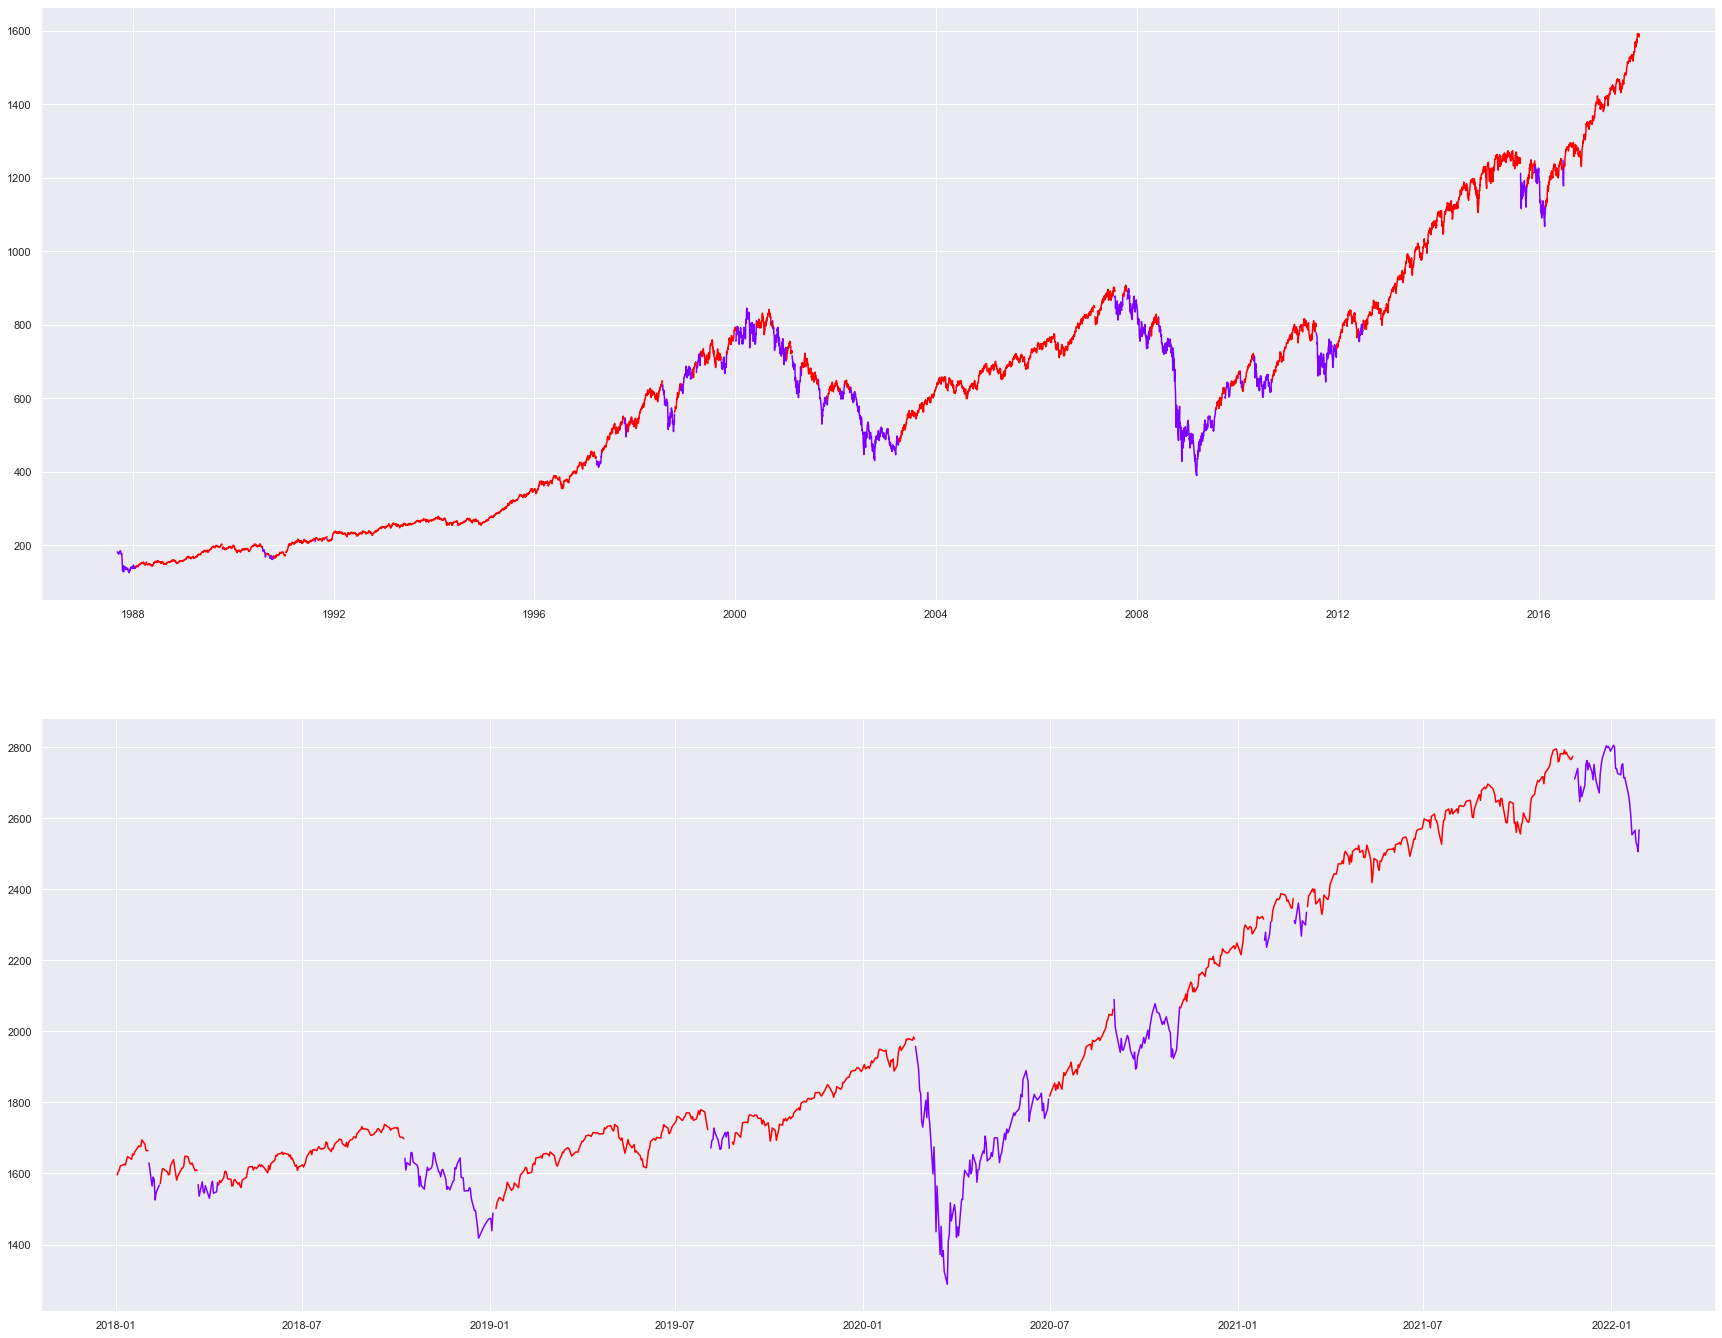

In [113]:
hidden_markov_train_test(df, num_states=2)

[[9.66151211e-01 2.68553273e-02 6.99346154e-03]
 [1.64257136e-02 9.83574229e-01 5.77052418e-08]
 [3.43331624e-02 9.22465581e-09 9.65666828e-01]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=3, n_iter=1000)>
Means and vars of each hidden state :


(<Figure size 2160x1728 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

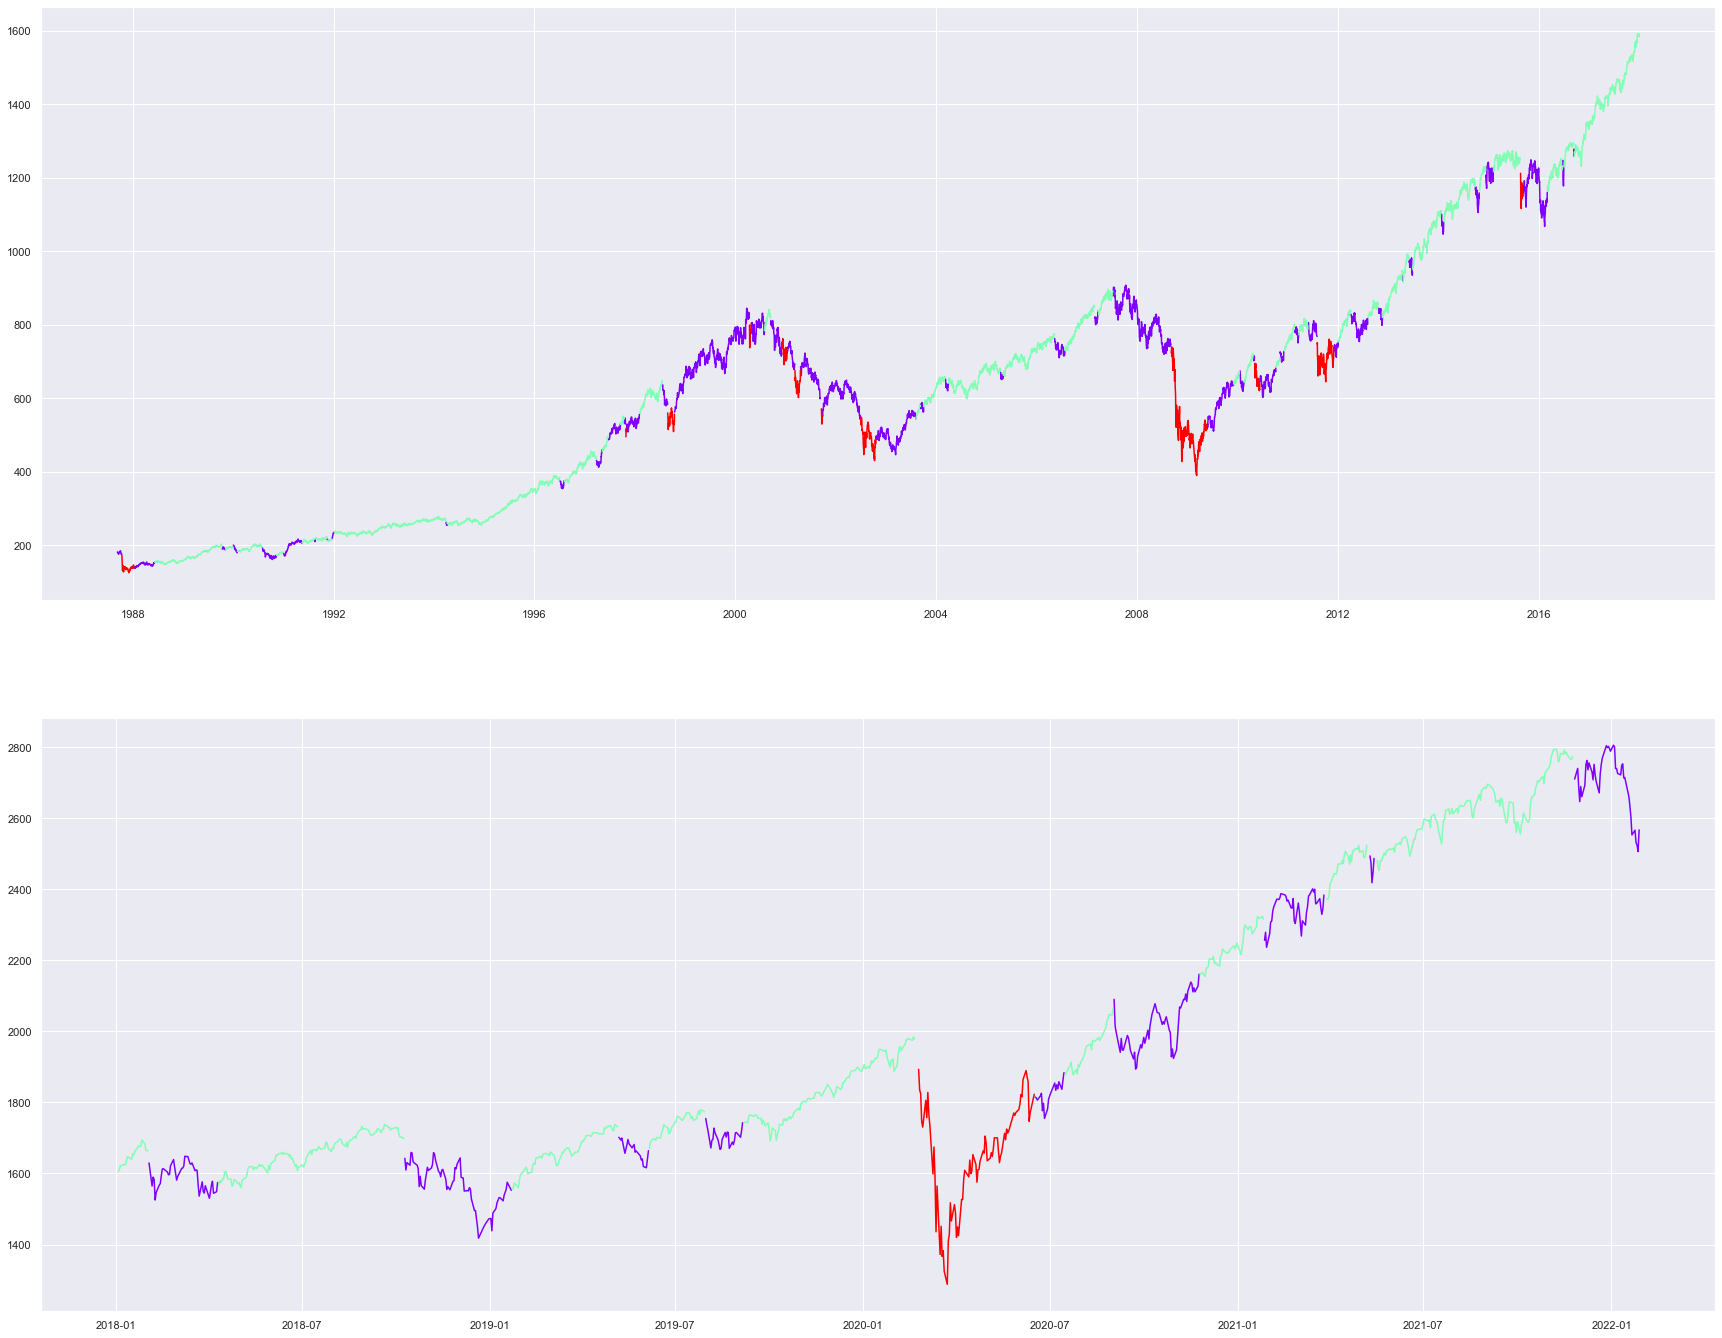

In [114]:
hidden_markov_train_test(df, num_states=3)

[[9.32058441e-01 6.66556118e-02 1.28594694e-03 7.86474070e-10]
 [6.58213987e-01 2.48102917e-01 9.36806706e-02 2.42504523e-06]
 [2.31078957e-03 1.81704676e-02 9.71472689e-01 8.04605357e-03]
 [7.56585009e-10 3.50893929e-07 3.79579425e-02 9.62041706e-01]]
<bound method _BaseHMM.predict_proba of GaussianHMM(n_components=4, n_iter=1000)>
Means and vars of each hidden state :


(<Figure size 2160x1728 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

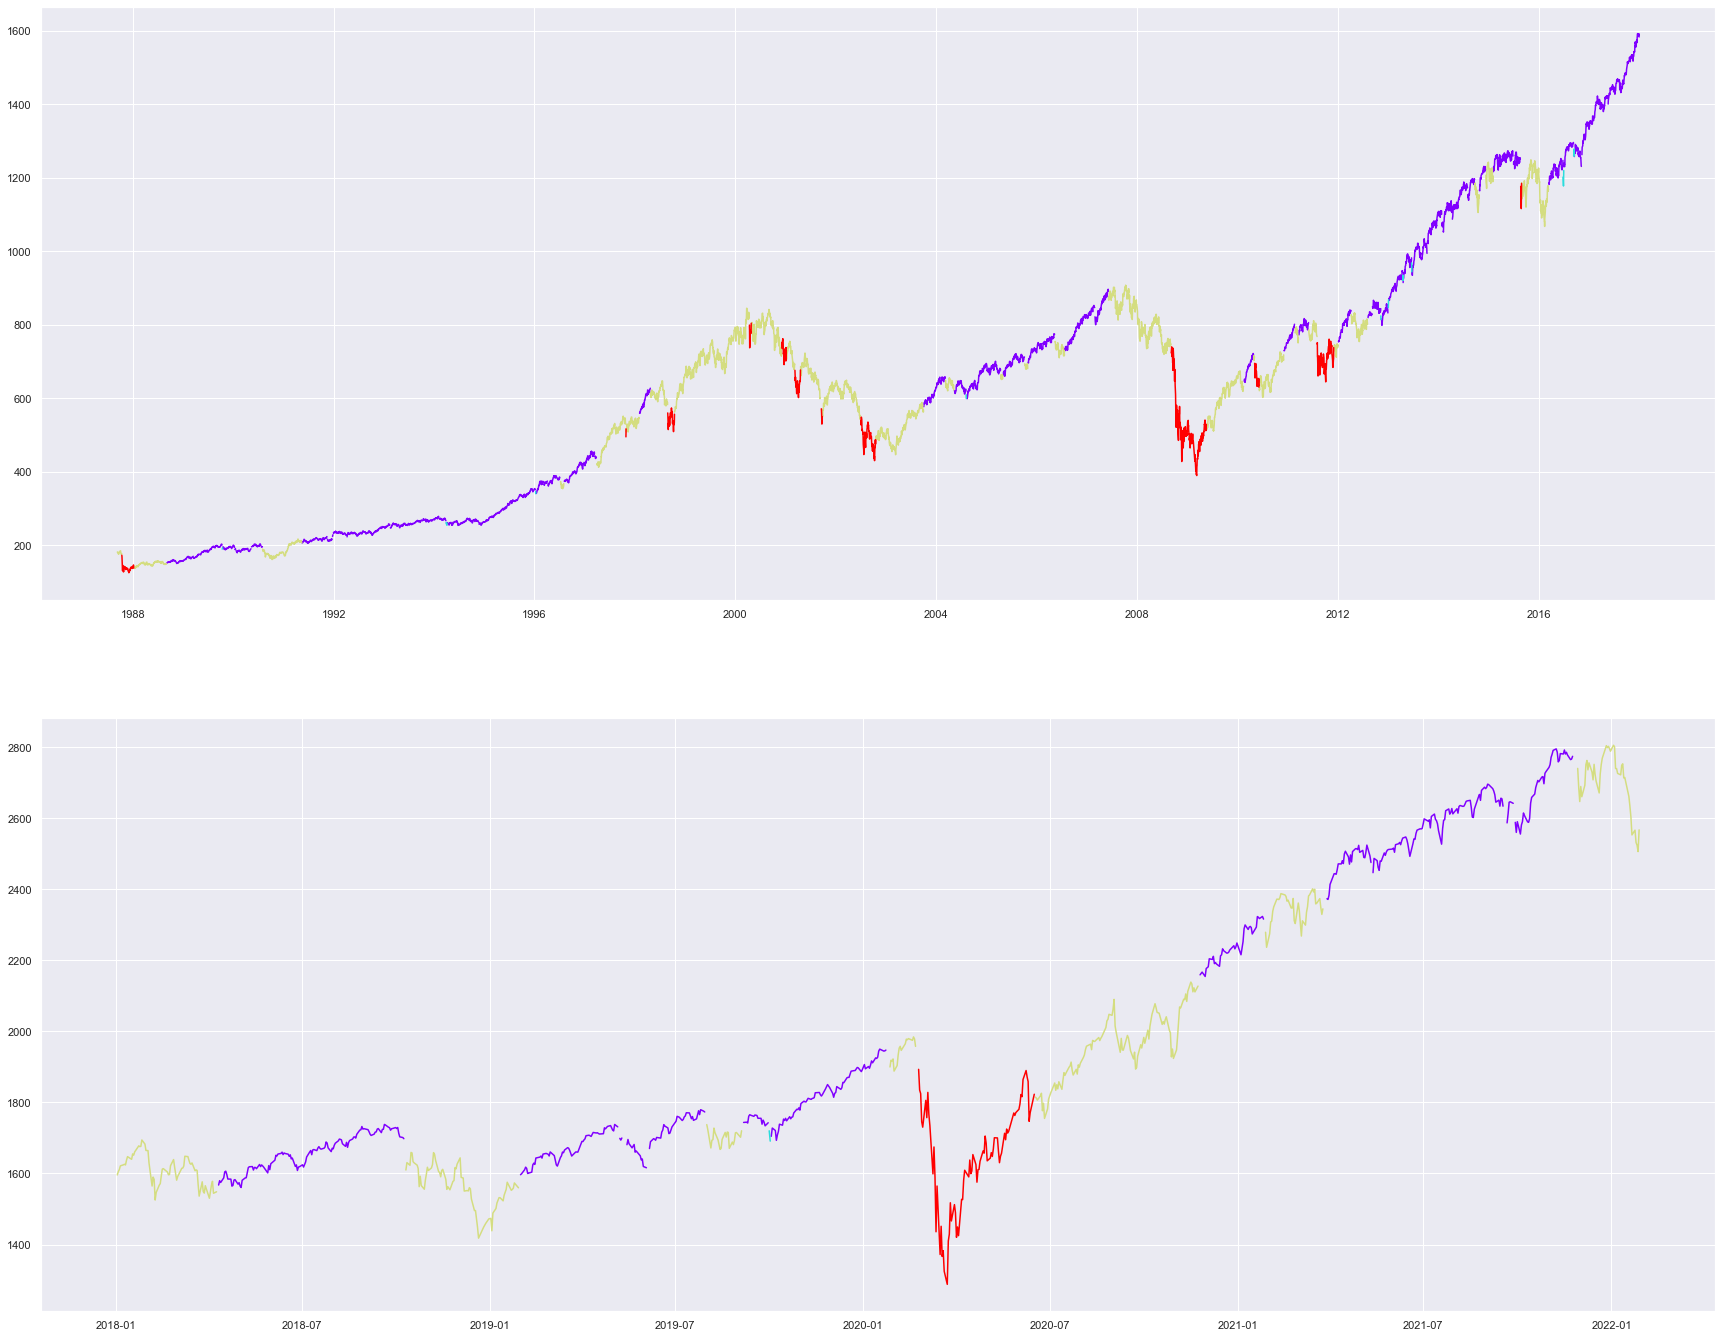

In [115]:
hidden_markov_train_test(df, num_states=4)